## Setup

In [2]:

# imports
%matplotlib inline
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from io import BytesIO

from transformers import AutoImageProcessor, AutoModelForImageClassification
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [3]:
# load model
model_name = "apple/mobilevitv2-1.0-imagenet1k-256"
processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)
model = AutoModelForImageClassification.from_pretrained(model_name)

Importing dog.jpg as a test

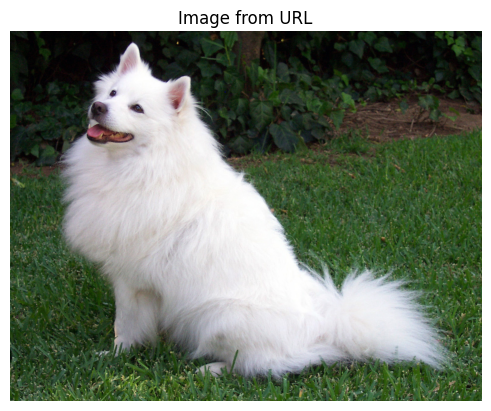

In [4]:
image_url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"

try:
  response = requests.get(image_url)
  response.raise_for_status()
  
  image_data = BytesIO(response.content)
  img = Image.open(image_data)
  
  plt.imshow(img)
  plt.axis('off')
  plt.title('Image from URL')
  plt.show()

except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")
except IOError as e:
    print(f"Error opening image with PIL: {e}")

Preprocess the image

In [5]:

img_processed = processor(img, return_tensors="pt")
input_tensor = img_processed['pixel_values'].to(model.device)

print(input_tensor.shape)

torch.Size([1, 3, 256, 256])


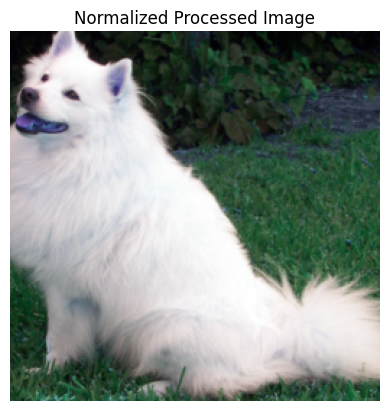

In [6]:
# remove batch dim and move to CPU
img_tensor = input_tensor.squeeze(0).cpu()

# convert to numpy and transpose to HWC for matplotlib
img_np = img_tensor.permute(1, 2, 0).numpy()

# clip values to a reasonable range for display, e.g., [-1, 1] to [0,1]
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

plt.imshow(img_np)
plt.axis('off')
plt.title('Normalized Processed Image')
plt.show()

Pass the image through the model and classify the image

In [7]:
outputs = model(input_tensor)
logits = outputs.logits
print(f"Shape of logits: {logits.shape}") 

target_idx_int = logits.argmax(dim=1).item()
print(f"Index of maximum classification: {target_idx_int}")

Shape of logits: torch.Size([1, 1000])
Index of maximum classification: 258


In [8]:
class_dict = model.config.id2label
class_readable = class_dict[target_idx_int]
print(f"Class: {class_readable}")

Class: Samoyed, Samoyede


## Using Grad-CAM
To use Grad-CAM, we must first find a convolutional layer (usually the last) that will work best for the desired output.

In [9]:
# print convolutional layers
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        print(f"{name}: {module}")

mobilevitv2.conv_stem.convolution: Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
mobilevitv2.encoder.layer.0.layer.0.expand_1x1.convolution: Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
mobilevitv2.encoder.layer.0.layer.0.conv_3x3.convolution: Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
mobilevitv2.encoder.layer.0.layer.0.reduce_1x1.convolution: Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
mobilevitv2.encoder.layer.1.layer.0.expand_1x1.convolution: Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
mobilevitv2.encoder.layer.1.layer.0.conv_3x3.convolution: Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=128, bias=False)
mobilevitv2.encoder.layer.1.layer.0.reduce_1x1.convolution: Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
mobilevitv2.encoder.layer.1.layer.1.expand_1x1.convolution: Conv2d(128, 256, kernel_size=(1, 1), str

In [10]:
# required to make GradCAM work with the model
class LogitsWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        return self.base_model(x).logits

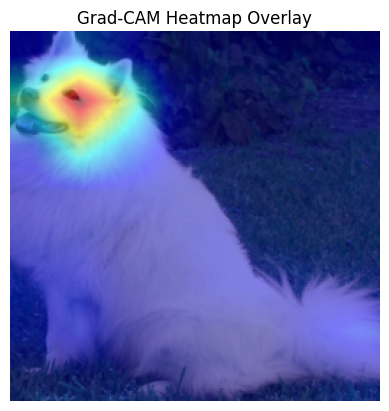

In [11]:
target_layers = [model.mobilevitv2.encoder.layer[4].conv_projection.convolution]
targets = [ClassifierOutputTarget(target_idx_int)]

wrapped_model = LogitsWrapper(model)
cam = GradCAM(model=wrapped_model, target_layers=target_layers)

grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
model_outputs = cam.outputs

plt.imshow(visualization)
plt.axis('off')
plt.title("Grad-CAM Heatmap Overlay")
plt.show()